<img style="float:right; max-width:300px" src="imgs/time-series-modelling.jpeg" width="60%" />

# Прогнозы временных рядов
Временной ряд — это совокупность наблюдений $x_t$, упорядоченных по времени. На основе независимой переменной $x$, которая представляет время, мы хотим спрогнозировать зависимую переменную $y$. Мы используем информацию о предыдущих наблюдениях ($y_t$ зависит не только от текущего $x_t$, но и от предыдущих наблюдений $x_{t-1}$, ...). Мы прогнозируем точки вне известного диапазона, поэтому используем экстраполяцию.

Далее мы будем иметь дело с моделями временных рядов, с помощью которых мы *предсказываем будущее* — на основе предыдущих наблюдений $x$ мы прогнозируем будущие наблюдения $y$. Затем мы смотрим на меры оценки, т.е. насколько хорошо модели предсказывают.

Для начала загружаем необходимые пакеты и датасет:

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (8, 4)
sb.set(font_scale=1.)

df = pd.read_csv('data/airline-passengers.csv', sep=',')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Чтобы иметь возможность оценить модель, нам нужен набор для проверки (имитированного теста). Как и раньше, мы разделим данные на обучающий и проверочный наборы в соотношении $80/$20. Все дальнейшие преобразования и обучение модели выполняются на обучающем наборе, а модель оценивается на проверочном наборе.

*Примечание. Обратите внимание, что мы не перемешиваем данные, когда устанавливаем shuffle=True (подумайте, почему).*

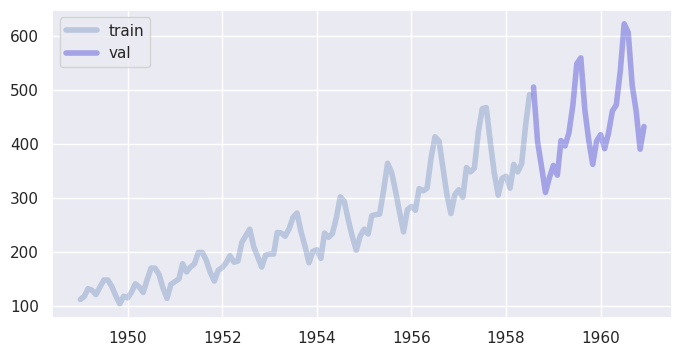

In [3]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

# 1-й способ — функция train_test_split(), которая возвращает числовые строки.
# x_train, y_train, x_val, y_val = train_test_split(df['Пассажиры'], df['Месяц'], train_size=0.8, shuffle=False)

# 2-й способ - эквивалент вышеописанному, только нам будет проще работать с объектом DataFrame
# извлекаем первые 80% в train_df и оставшиеся 20% в val_df
dataset_split = int(len(df['Passengers']) * 0.8)
train_df = df[:dataset_split].copy()
val_df  =  df[dataset_split:].copy()

plt.plot(train_df['Passengers'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['Passengers'], color='mediumblue', linewidth=4, alpha=0.3, label='val')
plt.legend()
plt.show()

Рассматриваемые нами модели требуют стационарного временного ряда. Вот почему мы ищем преобразования, которые приведут к стационарному временному ряду.

In [4]:
# логарифмизация и 2х дифференцирование привели нас к стационарности
train_df['log10(Passengers)'] = np.log10(train_df['Passengers'])
train_df['stationary_data'] = train_df['log10(Passengers)'].diff().diff()

p_value = adfuller(train_df['stationary_data'].dropna())[1]
if p_value <= 0.05: print('есть стационарность')
else: print('нет никакой стационарности')

есть стационарность


Мы определили, какие преобразования приводят нас к стационарности и сохранили их в столбце `stationary_data`. Мы заключаем, что логарифмирование и двойное дифференцирование приводят к стационарным данным. Однако мы не будем использовать столбец `stationary_data`, а вместо этого будем использовать столбец `log10(Passengers)`, а двойное дифференцирование оставим пакету `statsmodels`.

## Модели
Ниже мы создаем 4 модели для временных рядов:

| Модель             | Описание         | Формула | Определение порядка модели | Вызов в пакете statsmodels |
|-------------------|--------------|---------|-------------------------|----------------------------|
| AR (AutoRegressive) авторегрессионная| Текущее значение является линейной комбинацией предыдущих $p$ значений. | $$Yar = Y_{t} = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} + \epsilon_t$$  | Для порядка модели AR используем значимые значения PACF. | `ARIMA(x_train, order=(p, 0, 0)).fit()` |
| MA (Moving Average) модель скользящего среднего| Текущее значение является линейной комбинацией предыдущих $q$ ошибок и некоторого значения.    | $$Yma = Y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \ldots + \theta_q \epsilon_{t-q}$$  | Для порядка модели MA используем значимые значения ACF. | `ARIMA(x_train, order=(0, 0, q)).fit()` |
| ARMA (AutoRegressive Moving Average) | Текущее значение является суммой AR и MA моделей.   | $$Y_t = Yar + Yma$$  | Для порядка модели AR используем значимые значения PACF, а для порядка модели MA используем значимые значения ACF. | `ARIMA(x_train, order=(p, 0, q)).fit()` |
| ARIMA (AutoRegressive Integrated Moving Average) | Текущее значение является суммой AR и MA моделей, с возможностью дифференцирования. | $$Y_t' = Yar' + Yma$$ | Для определения порядка AR и MA моделей используем значимые значения PACF и ACF после дифференцирования ряда, если необходимо. | `ARIMA(x_train, order=(p, d, q)).fit()`|

Последний столбец указывает, как вызвать каждую модель. Каждую модель можно вывести из модели ARIMA, изменяя соответствующие параметры. Ниже показан процесс обучения и оценки модели AR, аналогично это применимо и к другим моделям.

### Модель AR
Как мы видели, после логарифмирования временного ряда, ряд нужно дифференцировать 2 раза. Это мы передаем пакету `statsmodels`, изменив параметр `d=2` на `order=(p, 2, q)`. Поскольку мы хотим только модель AR, без модели MA, мы знаем, что `q=0`, то есть `order=(p, 2, 0)`. Остается определить параметр `p` - порядок модели AR - мы определяем через график PACF, выбирая значимое значение.

*Примечание: ACF и PACF анализируются на стационарных данных для определения порядка модели.*


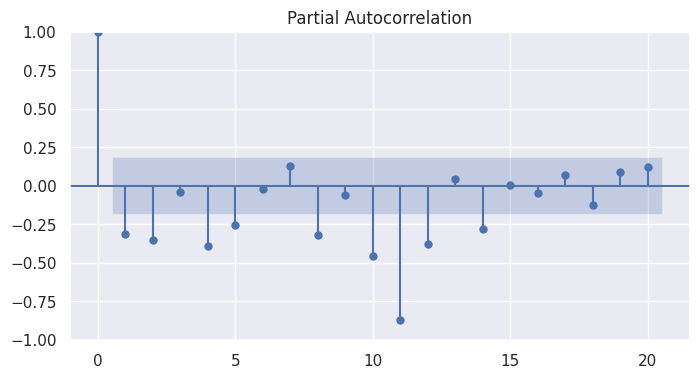

In [5]:
plot_pacf(train_df['stationary_data'].dropna(), lags=20, method='ols')
plt.show()

По ACF графику мы видим, что значимые значения для $p=1,2,4,5,8, 10, 11, 12, 14$.
Мы проверяем последние несколько значимых значений для $p$ (в данном случае выбрали бы $p=14$), но используем доменное знание о том, что есть сезонность каждые 12 месяцев, поэтому выбираем $p=12$.

*Примечание: изменение параметра `method` может привести к разным графикам. Например, при использовании стандартного параметра `method='ywm'`, будет предложено выбрать $p=13$ для модели AR. Необходимо попробовать обе опции.*

Мы знаем, что $p=12$ и $d=2$, поэтому используем `order=(12, 2, 0)` и обучаем модель AR:


In [6]:
p, d, q = 12, 2, 0
ar_model = ARIMA(train_df['log10(Passengers)'], order=(p, d, 0)).fit()
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:      log10(Passengers)   No. Observations:                  115
Model:                ARIMA(12, 2, 0)   Log Likelihood                 277.174
Date:                Thu, 08 Feb 2024   AIC                           -528.348
Time:                        17:25:10   BIC                           -492.892
Sample:                    01-01-1949   HQIC                          -513.960
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3303      0.078    -16.991      0.000      -1.484      -1.177
ar.L2         -1.3162      0.094    -14.070      0.000      -1.500      -1.133
ar.L3         -1.3489      0.096    -14.052      0.0

#### Прогнозы
Мы делаем прогнозы, вызывая метод `predict(start, end)`, где `start` представляет начальную дату, а `end` конечную дату. Сначала мы посмотрим, как выглядят прогнозы модели на обучающих данных.

Поскольку мы выбрали $p=12$, это означает, что модель должна получить предыдущие 12 данных, чтобы предсказать 13-ый. Поэтому, когда мы делаем прогноз, мы начинаем с 13-го наблюдения и далее.

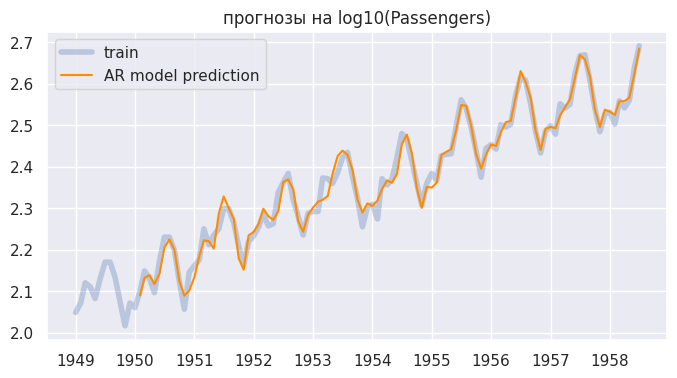

In [7]:
y_train_pred = ar_model.predict(start=train_df.index[p+1], end=train_df.index[-1])

plt.plot(train_df['log10(Passengers)'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(y_train_pred, color='darkorange', label='AR model prediction')
plt.title('прогнозы на log10(Passengers)')
plt.legend()
plt.show()

Видимо, что модель хорошо справляется с обучающими данными. Проверим, как она работает на валидационных данных:

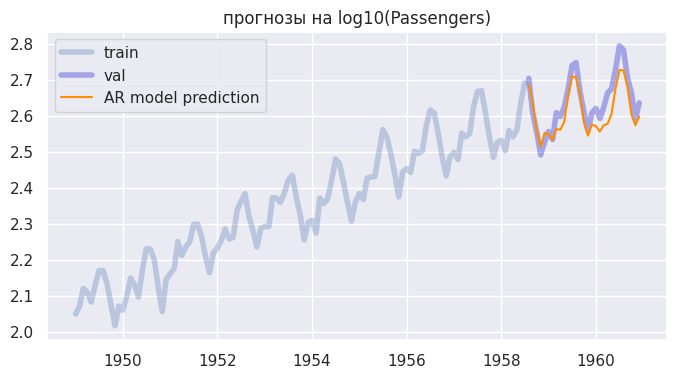

In [8]:
val_df['log10(Passengers)'] = np.log10(val_df['Passengers'])
y_val_pred = ar_model.predict(start=val_df.index[0], end=val_df.index[-1])

plt.plot(train_df['log10(Passengers)'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['log10(Passengers)'], color='mediumblue', linewidth=4, alpha=0.3, label='val')

plt.plot(y_val_pred, color='darkorange', label='AR model prediction')
plt.title('прогнозы на log10(Passengers)')
plt.legend()
plt.show()

В настоящее время мы показываем прогнозы по логарифмическим данным. Как отображать прогнозы по исходным данным?

##### Отображение прогноза на исходном временном ряде
Модели передаются логарифмированные данные, затем они дифференцируют и, након этого, обучают модель (находят параметры модели).
Чтобы получить исходные значения, необходимо выполнить обратные операции в обратном порядке. Конкретно, нам нужно выполнить две обратные операции от дифференцирования (операция cumsum), а затем обратную операцию от логарифмирования (экспоненцирование).
Обратная операция от дифференцирования автоматически выполняется при вызове метода `predict()` из `statsmodels`, поэтому нам остается только экспоненцировать данные.

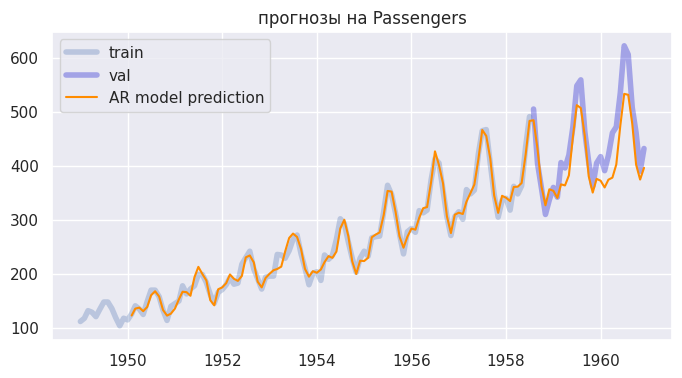

In [9]:
# предсказание автоматически выполняет обратное дифференцирование
y_pred = ar_model.predict(start=train_df.index[p+1], end=val_df.index[-1])
# возведение в степень
y_pred = np.power(10, y_pred)

plt.plot(train_df['Passengers'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['Passengers'], color='mediumblue', linewidth=4, alpha=0.3, label='val')
plt.plot(y_pred, color='darkorange', label='AR model prediction')
plt.title('прогнозы на Passengers')
plt.legend()
plt.show()

### Модель ARIMA
Мы создаем модель ARIMA (комбинация моделей AR и MA), чтобы сравнить производительность обеих моделей. Мы уже установили, что для достижения стационарности нам необходимо двукратное дифференцирование $d=2$, а порядок AR модели равен $p=12$, что приводит к параметрам `order=(12, 2, q)`. Остается определить порядок MA модели, и для этого мы используем информацию с ACF графика.

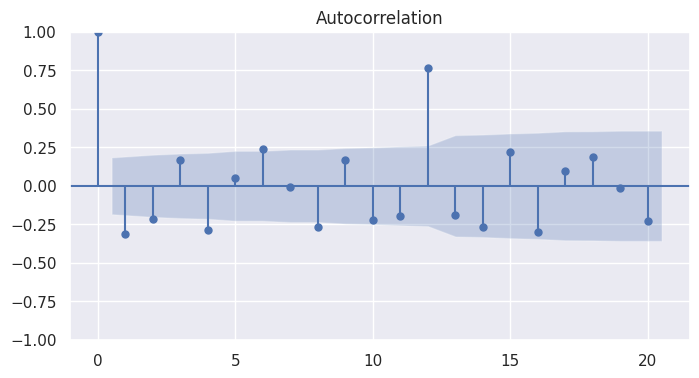

In [10]:
plot_acf(train_df['stationary_data'].dropna(), lags=20)
plt.show()

На ACF графике мы ищем значимые значения $q$, после которых происходит резкое снижение. Мы видим, что после $q=2$ происходит резкое снижение, поэтому мы заключаем, что предпредыдущий месяц имеет значительное прямое влияние. Мы выбираем $q=2$.

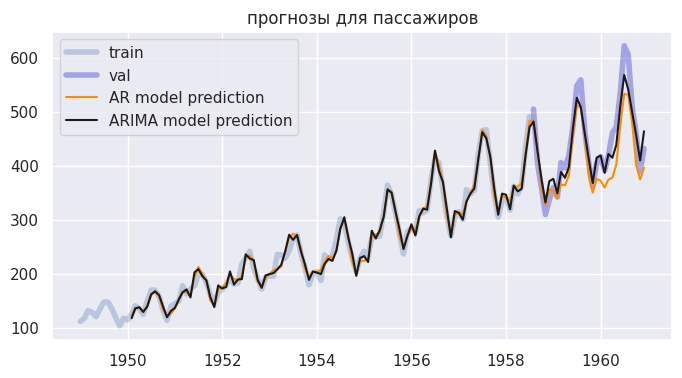

In [11]:
p, d, q = 12, 2, 2
arima_model = ARIMA(train_df['log10(Passengers)'], order=(p, d, q)).fit()

y_pred_arima = arima_model.predict(start=train_df.index[p+1], end=val_df.index[-1])
y_pred_arima = np.power(10, y_pred_arima)

plt.plot(train_df['Passengers'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['Passengers'], color='mediumblue', linewidth=4, alpha=0.3, label='val')
plt.plot(y_pred, color='darkorange', label='AR model prediction')
plt.plot(y_pred_arima, color='k', label='ARIMA model prediction')
plt.title('прогнозы для пассажиров')
plt.legend()
plt.show()

## Оценка
С графика мы видим, что модель хорошо соответствует данным. Финальный шаг - оценка моделей. Мы сравним модель AR и модель ARIMA.

| Метрика | Формула |
|---------|---------|
| MSE (Mean Squared Error) | $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \lvert Y_i - \hat{Y}_i \rvert^2 $ |
| RMSE (Root Mean Squared Error) | $ \text{RMSE} = \sqrt{\text{MSE}} $ |
| MAE (Mean Absolute Error) | $ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \lvert Y_i - \hat{Y}_i \rvert $ |
| MAPE (Mean Absolute Percentage Error) | $ \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \frac{\lvert Y_i - \hat{Y}_i \rvert}{\lvert Y_i \rvert} \times 100 \% $ |
| MASE (Mean Absolute Scaled Error) | $ \text{MASE} = \frac{\text{MAE}}{\frac{1}{n-1} \sum_{i=2}^{n} \lvert Y_i - Y_{i-1} \rvert} $ |

Каждая метрика имеет свои преимущества и недостатки. Какая наиболее подходит, зависит от решаемой проблемы (более подробно на лекциях).

In [12]:
# импортируем необходимые метрики (для практики попробуйте написать их самостоятельно)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mse = mean_squared_error
mae = mean_absolute_error
mape = mean_absolute_percentage_error

actual = val_df['Passengers']
ar_pred = ar_model.predict(start=val_df.index[0], end=val_df.index[-1])
ar_pred = np.power(10, ar_pred) # мы возводим в степень, потому что сравниваем со столбцом «Пассажиры», а не с «log10(Пассажиры)»
print('Оценка модели AR по набору проверки:')
print(f'{mse(actual, ar_pred)=:.2f}', f'{mae(actual, ar_pred)=:.2f}')

arima_pred = arima_model.predict(start=val_df.index[0], end=val_df.index[-1])
arima_pred = np.power(10, arima_pred) # мы возводим в степень, потому что сравниваем со столбцом «Пассажиры», а не с «log10(Пассажиры)»
print('\nОценка модели ARIMA по набору проверки:')
print(f'{mse(actual, arima_pred)=:.2f}', f'{mae(actual, arima_pred)=:.2f}')

Оценка модели AR по набору проверки:
mse(actual, ar_pred)=1782.29 mae(actual, ar_pred)=35.27

Оценка модели ARIMA по набору проверки:
mse(actual, arima_pred)=694.02 mae(actual, arima_pred)=20.62


Оценка по текущим меркам показывает, что модель ARIMA лучше, чем модель AR, что мы также видели на графиках. Текущий способ оценки модели измеряет, насколько хорошо модель предсказывает с 1958-07-01 (последнее известное значение в тренировочном наборе) до 1960-12-01 (последнее известное значение в валидационном наборе), что составляет период в 29 месяцев. Нас действительно интересует количество пассажиров на такой дальний временной период? Обычно нет. В большинстве случаев нас интересует только одно предсказание вперед. В этом случае нам нужна *Walk-Forward* оценка.

### *Walk-Forward* оценка
Мы итеративно предсказываем следующий временной момент, при этом на каждой итерации мы обучаем модель, добавляя в тренировочный набор реальное значение (которое мы получаем из валидационного набора). Идея заключается в том, чтобы новое измеренное значение добавлялось в тренировочный набор данных, чтобы мы всегда предсказывали только следующий временной момент. Такая оценка модели наиболее соответствует реальности.

ARIMA walk-forward оценка на валидационном наборе данных:
mse(actual, wf_pred)=344.10 mae(actual, wf_pred)=14.25


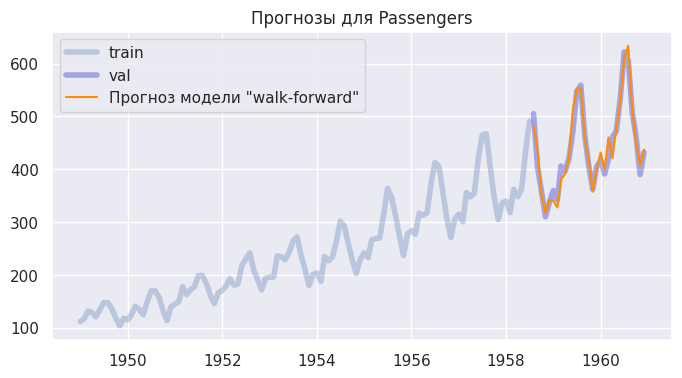

In [13]:
def walk_forward_loop(train_df, val_df, column_name, order=(0, 0, 0)):
    history = train_df[column_name].copy() # обучающий набор данных, который мы расширяем реальными значениями
    wf_pred = pd.Series() # серия прогнозов, которую мы заполняем итеративно
    
    for i in range(len(val_df)):
        wf_model = ARIMA(history, order=order).fit()
        # сохраняем прогноз
        y_pred = wf_model.forecast(steps=1)
        wf_pred = pd.concat([wf_pred, y_pred])
        # сохраняем реальное значение в обучающий набор данных
        true_value = pd.Series(data=val_df.iloc[i][column_name], index=[val_df.index[i]])
        history = pd.concat([history, true_value])
    
    return wf_pred

# оцениваем
actual = val_df['Passengers']
wf_pred = walk_forward_loop(train_df, val_df, column_name='log10(Passengers)', order=(p, d, q))
wf_pred = np.power(10, wf_pred)
print('ARIMA walk-forward оценка на валидационном наборе данных:')
print(f'{mse(actual, wf_pred)=:.2f}', f'{mae(actual, wf_pred)=:.2f}')

# строим график
plt.plot(train_df['Passengers'], color='b', linewidth=4, alpha=0.3, label='train')
plt.plot(val_df['Passengers'], color='mediumblue', linewidth=4, alpha=0.3, label='val')
plt.plot(wf_pred, color='darkorange', label='Прогноз модели "walk-forward"')
plt.title('Прогнозы для Passengers')
plt.legend()
plt.show()

## Задачи
**TODO 1**: Загрузите временной ряд для числа пассажиров, используя [data/airline-passengers.csv](data/airline-passengers.csv). Затем:
1. Разделите временной ряд на тренировочный и валидационный наборы данных в соотношении 70:30.
2. Проверьте, отсортированы ли данные.
3. Создайте лучшую модель MA (скользящее среднее) и выведите значение RMSE для модели, используя оценку *walk-forward*.
4. Нарисуйте график предсказаний.
5. Создайте модель MA, используя все данные, и оцените, сколько пассажиров ожидается в первом квартале 1961 года.
6. Создайте модель ARIMA (используя все данные), чтобы ее прогнозы для первого квартала 1961 года были ближе к модели MA. Предположим, что порядок AR модели $p \neq 0$.